In [317]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

## Load and combine the test and train data for processing

In [318]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train['in_train'] = True
test['in_train'] = False

combined = pd.concat([train, test], axis=0, ignore_index=True)

## Quick exploration and formatting of the data

In [319]:
print (combined.shape)
print (combined.dtypes)

(1309, 13)
Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived       float64
Ticket          object
in_train          bool
dtype: object


In [320]:
# Rename some of the columns to shorter or more desctiptive names
combined = combined.rename(columns={'Parch' : 'ParChld', 'PassengerId' : 'ID', 
                                    'Pclass' : 'Class'})

# Separate continuous and categorical variables
continuous_vars = ['Age', 'Fare']
categorical_vars = ['Cabin', 'Embarked', 'Name', 'ParChld', 'Class', 'Sex', 'SibSp',
                    'Survived']

In [321]:
# Summary of the continuous variables
combined[continuous_vars].describe()

/opt/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Age,Fare
count,1046.000000,1308.000000
mean,29.881138,33.295479
std,14.413493,51.758668
min,0.170000,0.000000
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,80.000000,512.329200


In [322]:
# Summary of the categorical variables
combined[categorical_vars].describe()

/opt/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,ParChld,Class,SibSp,Survived
count,1309.000000,1309.000000,1309.000000,891.000000
mean,0.385027,2.294882,0.498854,0.383838
std,0.865560,0.837836,1.041658,0.486592
min,0.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,NaN
50%,0.000000,3.000000,0.000000,NaN
75%,0.000000,3.000000,1.000000,NaN
max,9.000000,3.000000,8.000000,1.000000


## Missing value analysis
- Cabin looks to be missing too many values to be useful
- Emabraked and Fare are missing 1 and 2 values, should be easily replaced
- Age may be a candidate for imputation

In [323]:
# Find the number of missing values for each column
combined.isnull().sum()

Age          263
Cabin       1014
Embarked       2
Fare           1
Name           0
ParChld        0
ID             0
Class          0
Sex            0
SibSp          0
Survived     418
Ticket         0
in_train       0
dtype: int64

### Embarked missing values
Looking at the missing Embarked values it appears that Fare, Sex, and Class may be the relevant variables that can be used to set Embarked

In [324]:
combined[combined.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,ParChld,ID,Class,Sex,SibSp,Survived,Ticket,in_train
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,True
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,True


Based on the table below it appears that the missing Emabraked values are either C or S as there are a very small number of Class 1 passengers with Embarked value of Q.

In [325]:
combined.groupby(['Embarked', 'Class', 'Sex']).agg({'Fare':[np.median, np.mean, 
                                                            np.count_nonzero]})

Fare                          
                         median        mean count_nonzero
Embarked Class Sex                                       
C        1     female  83.15830  118.895949          71.0
               male    62.66875   94.622560          70.0
         2     female  27.72080   27.003791          11.0
               male    15.04580   20.904406          17.0
         3     female  14.45420   13.834545          31.0
               male     7.22920    9.775901          70.0
Q        1     female  90.00000   90.000000           2.0
               male    90.00000   90.000000           1.0
         2     female  12.35000   12.350000           2.0
               male    12.35000   11.489160           5.0
         3     female   7.75000    9.791968          56.0
               male     7.75000   10.979167          57.0
S        1     female  78.85000  101.069145          69.0
               male    35.50000   53.670756         101.0
         2     female  23.00000   23.023118          93.0
               male    13.00000   20.073322         143.0
         3     female  13.77500   18.083851         129.0
               male     8.05000   13.145977         362.0

In the table above Embarked C and Embarked S have very similar n, Fare median, and Fare mean for female, Class 1 passengers so there is no good reason to pick one over the other.

Because the summary statistics of Ebarked C and Embarked S are to similar to make a judgement we need to look at the distributions.

/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


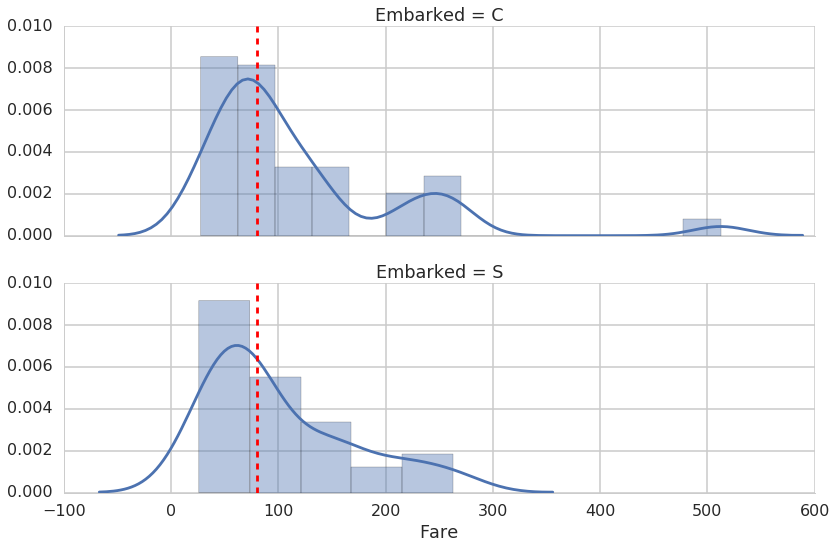

In [326]:
# Look at the distributions for female, Class 1, passengers with Embarked value C.
c = combined
c = c[(c.Sex == 'female') & ((c.Embarked == 'C') | (c.Embarked == 'S')) & (c.Class == 1)]
g = sns.FacetGrid(c, row='Embarked', row_order=['C', 'S'], size=4, aspect=3)
g.map(sns.distplot, 'Fare')

# Add a line at Fare = 80 which is the value for both missing cases
for ax in g.axes.flat:
    ax.plot((80,80), (0, 0.01), color='r', ls='--')

It's very close but it looks like there is a little bit higher density at the Fare value 80 for Embarked value of C so we will replace our missing values with C.

In [327]:
# Replace the missing Embarked values with 'C'.
combined.loc[combined.Embarked.isnull(), 'Embarked'] = 'C'

### The missing Fare value
Similar to above we will look at Fare by Sex, Embarked, and Class

In [328]:
combined[combined.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,ParChld,ID,Class,Sex,SibSp,Survived,Ticket,in_train
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,False


/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


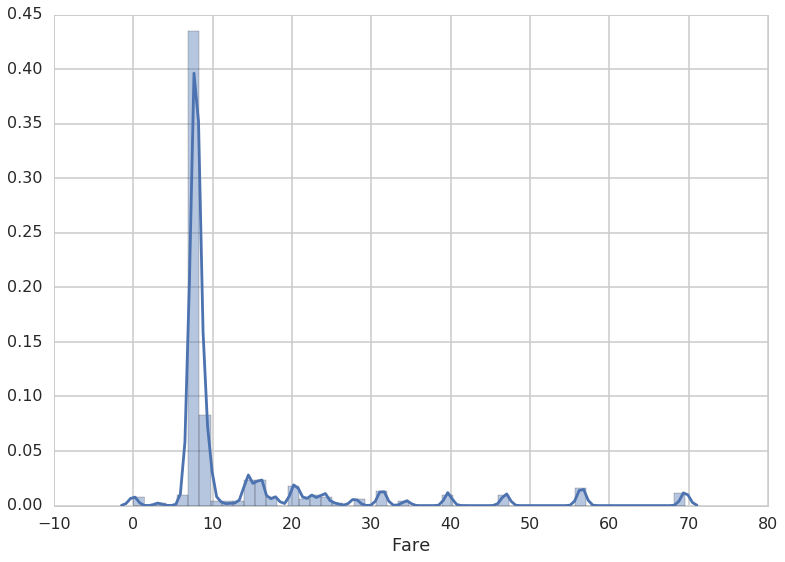

In [329]:
c = combined
c = c[(c.Sex == 'male') & (c.Embarked == 'S') & (c.Class == 3)]
sns.distplot(c.Fare[c.Fare.notnull()])

The distribution above shows that the mean sould skew a little high so the median should be used to replace the missing Fare value.

In [330]:
# Replace the missing Fare value with the median based on Sex, Embarked, and Class from the
# table above.
combined.loc[combined.Fare.isnull(), 'Fare'] = 8.05

## Extract Title and Surname from the Name column
The Name column contains a Title and Surname which may provide more information serving as extra variables

In [331]:
import re

def getSurname(name):
    surname = re.search('(.*,)', name)
    return surname.group(0)[:-1] if surname else None

def getTitle(name):
    title = re.search('(, .*?\.)', name)
    return title.group(0)[2:-1] if title else None

combined['Surname'] = combined['Name'].apply(lambda x: getSurname(x))
combined['Title'] = combined['Name'].apply(lambda x: getTitle(x))

In [332]:
c = combined
c.groupby(['Sex', 'Title']).size()

Sex     Title       
female  Dona              1
        Dr                1
        Lady              1
        Miss            260
        Mlle              2
        Mme               1
        Mrs             197
        Ms                2
        the Countess      1
male    Capt              1
        Col               4
        Don               1
        Dr                7
        Jonkheer          1
        Major             2
        Master           61
        Mr              757
        Rev               8
        Sir               1
dtype: int64

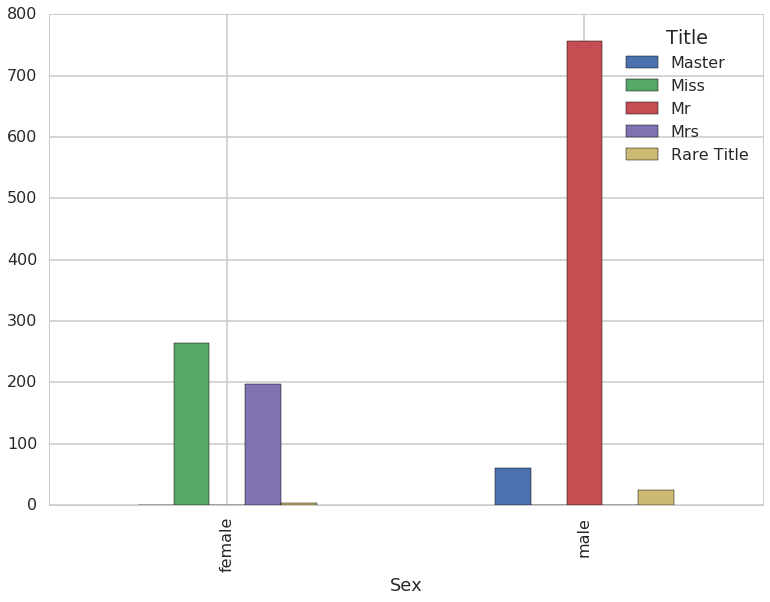

In [333]:
# Some binning of rare titles and googling to find synonomous titles
rare_title = ['Capt', 'Col', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir', 
              'the Countess']
combined.loc[combined['Title'] == 'Mlle', 'Title'] = 'Miss'
combined.loc[combined['Title'] == 'Ms', 'Title'] = 'Miss'
combined.loc[combined['Title'] == "Mme", 'Title'] = "Mrs"
combined.loc[combined['Title'].isin(rare_title), 'Title'] = 'Rare Title'

combined.groupby(['Sex', 'Title']).size().unstack().fillna(0).plot(kind='bar')

## Missing age values

In [334]:
# Create a dataframe of median ages by Class, Sex, and Title
median_ages = combined.groupby(['Class', 'Sex', 'Title']).agg({'Age':np.median}).unstack()
median_ages.columns = median_ages.columns.droplevel(0)
median_ages = pd.melt(median_ages.reset_index(), id_vars=['Class', 'Sex'], 
                      value_name='median_age')

# Merge with the median_ages df on Class, Sex, and Title
c = combined
c = c.merge(median_ages, how='left', on=['Class', 'Sex', 'Title'])

# Replace the missing Age values with the corresponding median age
missing_indexes = c[c.Age.isnull()].index
combined.ix[missing_indexes, 'Age'] = c.ix[missing_indexes, 'median_age']

In [339]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

c = combined
X_variables = ['Age', 'Embarked', 'Fare', 'ParChld', 'Class', 'Sex', 'SibSp', 'Title']

# Lable Encode the factor variables: Embarked, Sex, Title
le_Embarked = LabelEncoder()
le_Sex = LabelEncoder()
le_Title = LabelEncoder()

c.Embarked = le_Embarked.fit_transform(c.Embarked)
c.Sex = le_Sex.fit_transform(c.Sex)
c.Title = le_Title.fit_transform(c.Title)

X_train = c.loc[c.in_train, X_variables]
y_train = c.loc[c.in_train, 'Survived']
X_test = c.loc[~c.in_train, X_variables]
y_test = c.loc[~c.in_train, 'Survived']

X_train.isnull().sum()
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

pred_train = rf_clf.predict_proba(X_train)
fpr, tpr, _ = roc_curve(y_train, pred_train[:,1])
roc_auc = auc(fpr, tpr)
print ('Training ROC AUC: {:04.3f}'.format(roc_auc))

pred_test = rf_clf.predict(X_test)
result = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': pred_test.astype(int)})
result.to_csv('result/result.csv', index=False, encoding='utf-8')

Training ROC AUC: 0.997
